## Example operational analysis using the augmented capabilities of the AEP class

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the augmented capabilities which have been added to the plant-level operational energy asssessment (OA) of a wind plant in the PRUF project. The La Haute-Borne wind farm is used here and throughout the example notebooks. 

The overall structure of the notebook follows the walk-through in the standard AEP example notebook '02_plant_aep_analysis,' to which we refer the reader for a detailed description of the steps needed to prepare the analysis. Here, we focus on the application of various approaches in the AEP calculation, with different time resolutions, regression inputs and regression models used.

In [2]:
# Import required packages
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
import copy

from project_ENGIE import Project_Engie
from operational_analysis.methods import plant_analysis

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [3]:
# Load plant object
project = Project_Engie('./data/la_haute_borne')

In [4]:
# Prepare data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


### Comparison 1: AEP calculation at monthly vs daily resolution

The raw plant and reanalysis data can be processed in different time resolutions. The following steps show how the data can be combined into monthly averages or daily averages, as specified by "time_resolution".

In [5]:
pa_monthly = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'M')

pa_daily = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D')

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


Let's view the result. For the meaning of the various terms in the dataframe, please refer to the standard AEP example notebook.

In [6]:
# View the monthly data frame
pa_monthly._aggregate.df.head()

,energy_gwh,energy_nan_perc,num_days_expected,num_days_actual,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,merra2,era5
time,,,,,,,,,,,,,,,,,
2014-01-01,1.279667,0.0,31,31,0.008721,0.000000,1.288387,0.006769,0.000000,0.0,0.0,False,True,True,True,7.227947,7.314878
2014-02-01,1.793873,0.0,28,28,0.005280,0.000000,1.799153,0.002934,0.000000,0.0,0.0,False,True,True,True,8.598686,8.347006
2014-03-01,0.805549,0.0,31,31,0.000151,0.000000,0.805700,0.000188,0.000000,0.0,0.0,False,True,True,True,5.207071,5.169673
2014-04-01,0.636472,0.0,30,30,0.002773,0.000000,0.639245,0.004338,0.000000,0.0,0.0,False,True,True,True,4.872304,4.756275
2014-05-01,1.154255,0.0,31,31,0.015176,0.000225,1.169656,0.012974,0.000192,0.0,0.0,False,True,True,True,6.351635,6.162751


In [7]:
# View the daily data frame
pa_daily._aggregate.df.head()

,energy_gwh,energy_nan_perc,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,merra2,era5
time,,,,,,,,,,,,,,,
2014-01-01,0.072340,0.0,0.000022,0.0,0.072363,0.000310,0.0,0.0,0.0,False,True,True,True,9.852159,9.423187
2014-01-02,0.084852,0.0,0.000048,0.0,0.084901,0.000570,0.0,0.0,0.0,False,True,True,True,11.024592,10.479423
2014-01-03,0.091516,0.0,0.000000,0.0,0.091516,0.000000,0.0,0.0,0.0,False,True,True,True,10.476681,11.036872
2014-01-04,0.041096,0.0,0.000008,0.0,0.041104,0.000201,0.0,0.0,0.0,False,True,True,True,8.068651,8.688835
2014-01-05,0.048664,0.0,0.000000,0.0,0.048664,0.000000,0.0,0.0,0.0,False,True,True,True,7.932043,7.729130


The following lines of code launch the Monte Carlo-based OA for AEP. We identify each source of uncertainty in the OA estimate and use that uncertainty to create distributions of the input and intermediate variables from which we can sample for each iteration of the OA code. 

We repeat the OA process "num_sim" times using different sampling combinations of the input and intermediate variables to produce a distribution of AEP values. Once again, for a detailed description of the steps in the OA process, please refer to the standard AEP example notebook.


In [8]:
# Run Monte-Carlo based OA - monthly resolution
pa_monthly.run(num_sim=1000)
# Run Monte-Carlo based OA - daily resolution
pa_daily.run(num_sim=1000)

INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 1000, 'reanal_subset': ['merra2', 'era5']}
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/esimley/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
100%|██████████| 1000/1000 [00:11<00:00, 86.44it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([1

The key results for the AEP analysis with monthly and daily resolution are shown below: distributions of AEP values from which uncertainty can be deduced. 

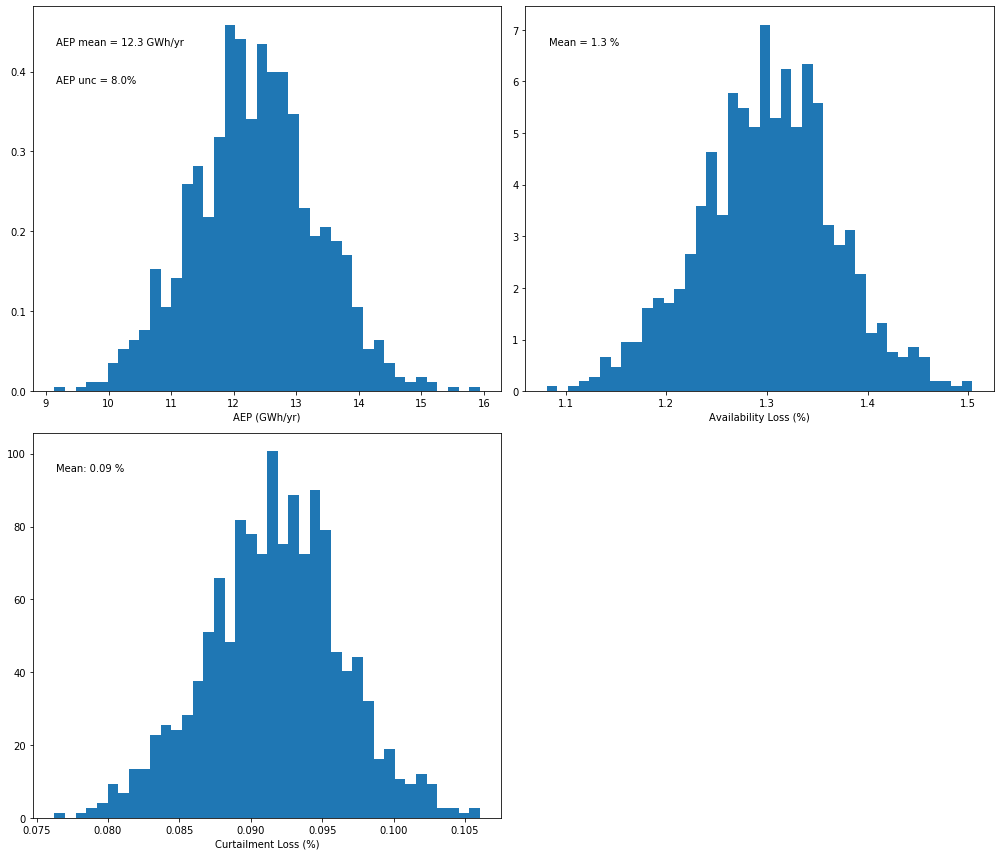

In [9]:
# Plot a distribution of AEP values from the Monte-Carlo OA method, monthly resolution
pa_monthly.plot_result_aep_distributions().show()

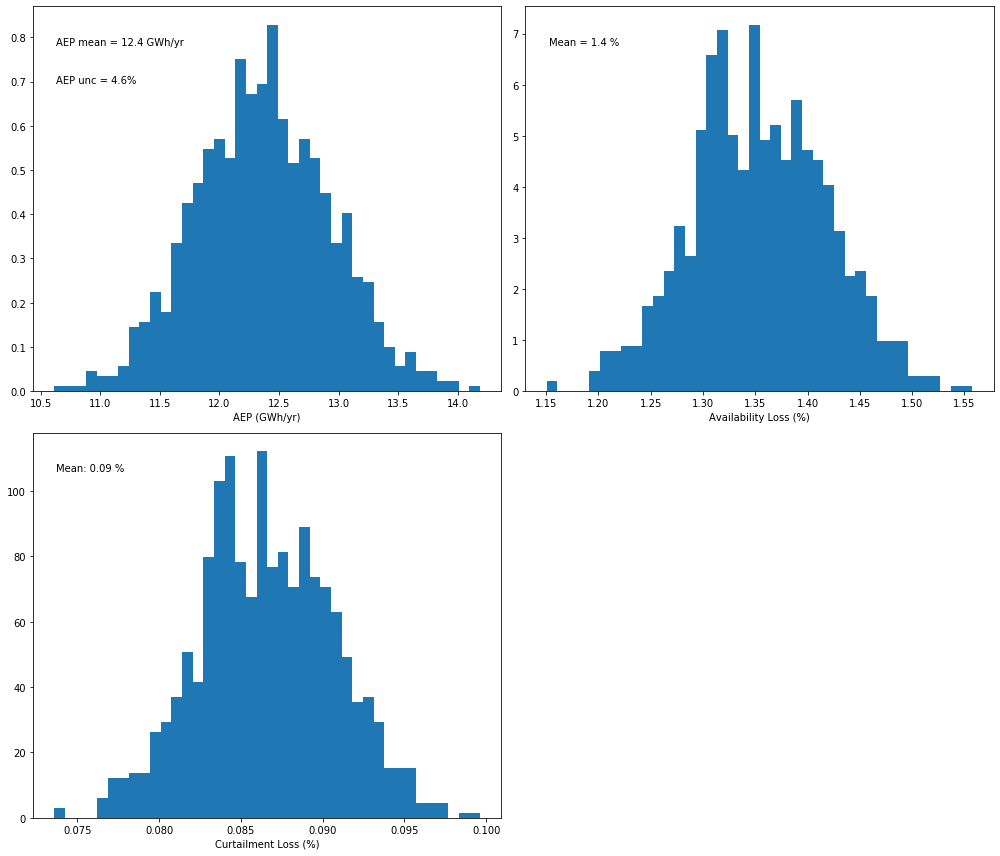

In [10]:
# Plot a distribution of AEP values from the Monte-Carlo OA method, daily resolution
pa_daily.plot_result_aep_distributions().show()

The most significant difference between the results for monthly and daily resolution is the lower AEP uncertainty resulting from AEP analysis with daily resolution.

### Comparison 2: AEP calculation using various input variables



The augmented capabilities of the AEP class now allow the user to include temperature and/or wind direction as additional inputs to the long-term OA. 
This choice is controlled by the booleans "reg_temperature" and "reg_winddirection".
In this example, we will perform the calculation at monthly resolution, but there is no restriction on the use of different sets of inputs at any resolution. The AEP analysis is performed using three combinations of inputs: 1) wind speed only, 2) wind speed and temperature, and 3) wind speed, temperature, and wind direction.

In [11]:
pa_ws = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'M')

pa_ws_temp = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'M', 
                                          reg_temperature = True)

pa_ws_temp_wd = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'M',
                                            reg_temperature = True, reg_winddirection = True)

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


As an example, the monthly data frame below now includes temperature and wind direction averages for both the reanalysis products selected for the analysis.

In [12]:
# View the monthly data frame
pa_ws_temp_wd._aggregate.df.head()

,energy_gwh,energy_nan_perc,num_days_expected,num_days_actual,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,...,merra2,merra2_temperature_K,merra2_u_ms,merra2_v_ms,merra2_wd,era5,era5_temperature_K,era5_u_ms,era5_v_ms,era5_wd
time,,,,,,,,,,,,,,,,,,,,,
2014-01-01,1.279667,0.0,31,31,0.008721,0.000000,1.288387,0.006769,0.000000,0.0,...,7.227947,276.325736,1.799250,5.094350,3.481102,7.314878,278.074322,1.952727,4.961290,3.516563
2014-02-01,1.793873,0.0,28,28,0.005280,0.000000,1.799153,0.002934,0.000000,0.0,...,8.598686,276.831294,3.136855,6.725968,3.577984,8.347006,278.523459,3.198897,6.385513,3.606009
2014-03-01,0.805549,0.0,31,31,0.000151,0.000000,0.805700,0.000188,0.000000,0.0,...,5.207071,279.554876,0.265724,0.475708,3.651004,5.169673,280.968796,-0.063400,0.379889,2.976225
2014-04-01,0.636472,0.0,30,30,0.002773,0.000000,0.639245,0.004338,0.000000,0.0,...,4.872304,283.504448,0.782350,-0.129176,4.876026,4.756275,284.467874,0.719363,-0.349016,5.164105
2014-05-01,1.154255,0.0,31,31,0.015176,0.000225,1.169656,0.012974,0.000192,0.0,...,6.351635,285.381422,1.651186,0.844470,4.239637,6.162751,285.889733,1.290779,0.733724,4.195502


We now run the Monte-Carlo based OA using the three combinations of input variables specified above.

In [13]:
# Run Monte-Carlo based OA - wind speed only
pa_ws.run(num_sim=1000)
# Run Monte-Carlo based OA - wind speed + temperature
pa_ws_temp.run(num_sim=1000)
# Run Monte-Carlo based OA - wind speed + temperature + wind direction
pa_ws_temp_wd.run(num_sim=1000)

INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 1000, 'reanal_subset': ['merra2', 'era5']}
100%|██████████| 1000/1000 [00:12<00:00, 77.00it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 1000, 'reanal_subset': ['merra2', 'era5']}
100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]
INFO:operational_analysis.methods.plant_analysis:Run completed
INFO:operational_analysis.methods.plant_analysis:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([

We can now compare the AEP distributions obtained for the three configurations of the OA.

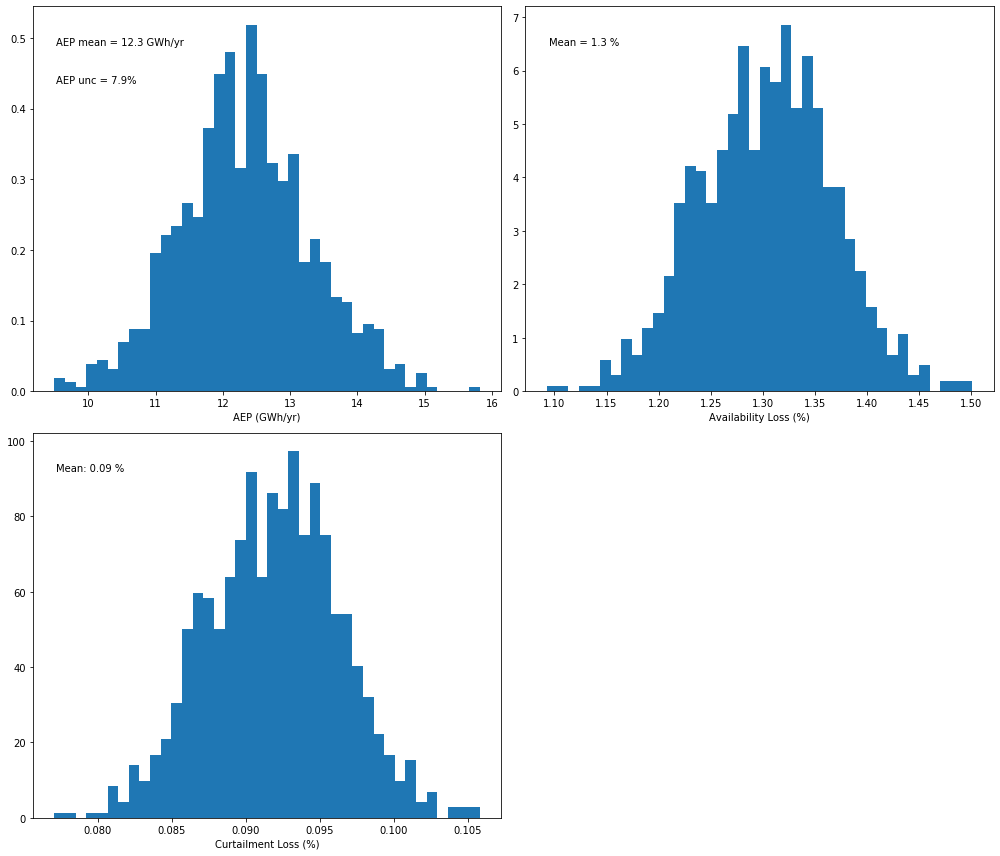

In [14]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed only
pa_ws.plot_result_aep_distributions().show()

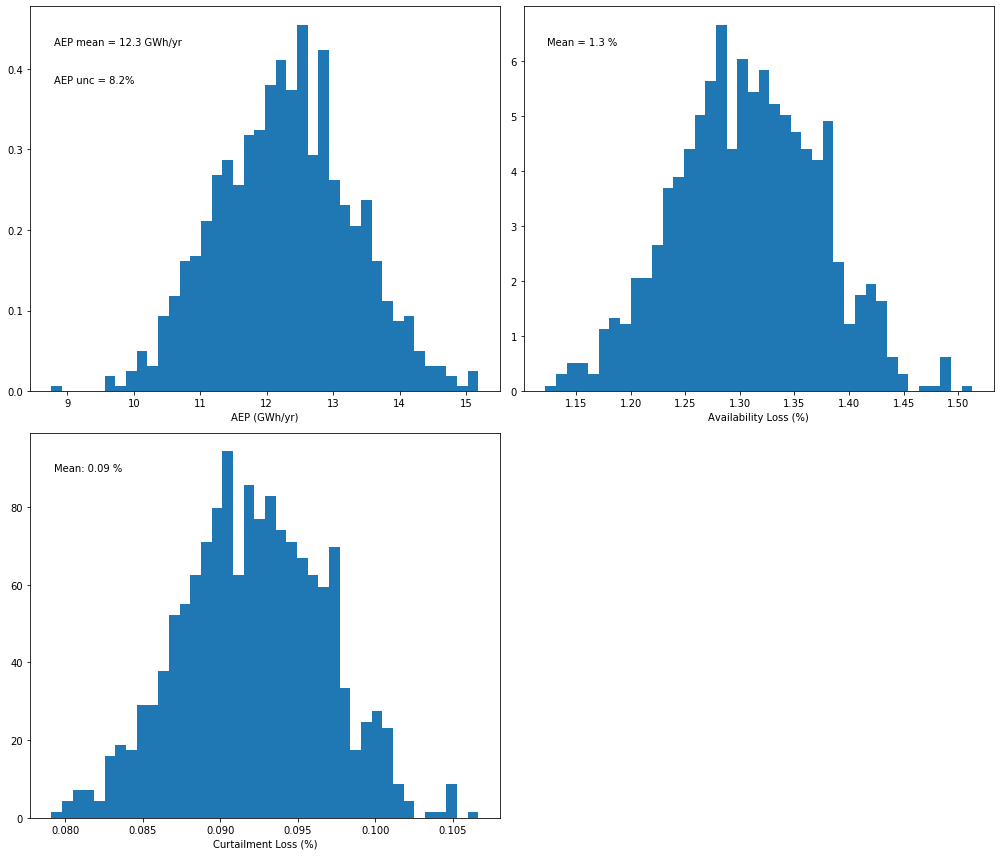

In [15]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed + temperature
pa_ws_temp.plot_result_aep_distributions().show()

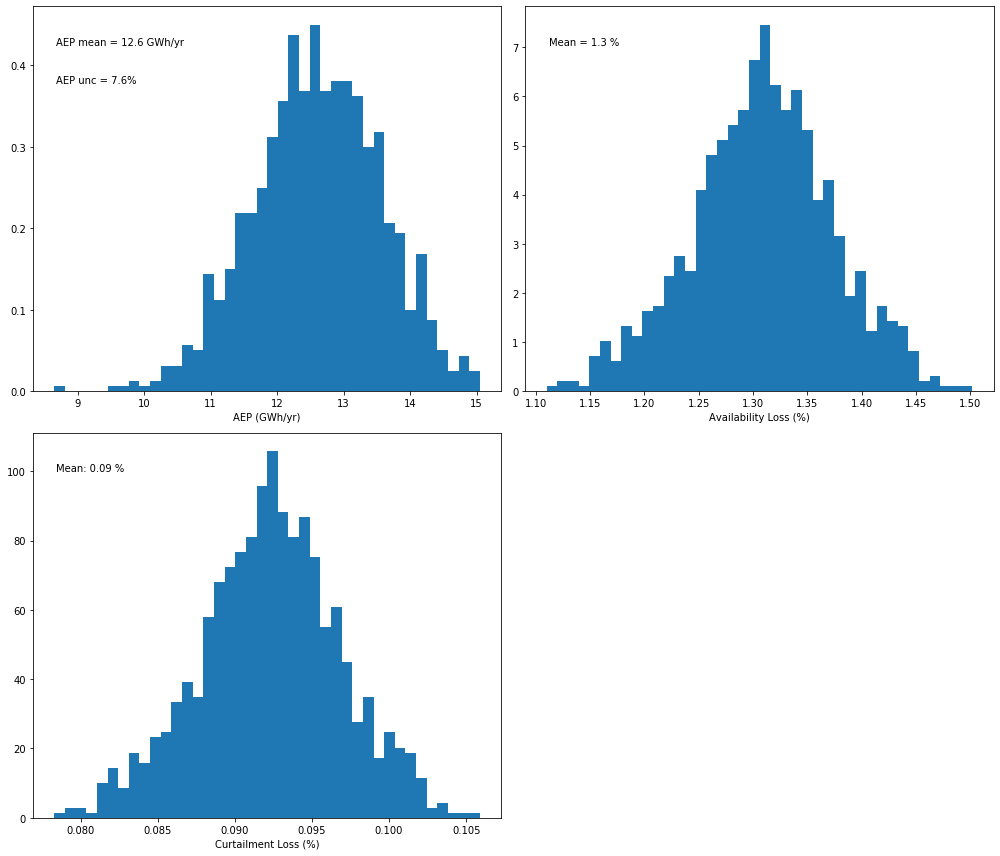

In [16]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed + temperature + wind direction
pa_ws_temp_wd.plot_result_aep_distributions().show()

Note that by including wind direction as an input to the regression model, the estimated AEP is slightly higher and the uncertainty is slightly lower.

### Comparison 3: AEP calculation using different regression models



The updated AEP class includes the choice of four different regression algorithms to calculate the long-term OA. The choice is based on what is specified by the reg_model parameter:
- linear regression (reg_model = 'lin', default)
- generalized additive regression model (reg_model = 'gam')
- gradient boosting regressor (reg_model = 'gbm')
- extremely randomized trees model (reg_model = 'etr')

Linear regression can be selected without restrictions. On the other hand, as machine learning models are more suited for problems with a large number of data points, we have restricted the use of gam, gbm and etr regressors to OA performed at daily resolution only.

Of course, all models can be used with any combination of input variables, as shown in the comparison 2.

Here, we'll calculate AEP using all three of the machine learning methods.

In [17]:
pa_gam = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D',
                                     reg_temperature = True, reg_winddirection = True, reg_model = 'gam')

pa_gbm = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D', 
                                         reg_temperature = True, reg_winddirection = True, reg_model = 'gbm')

pa_etr = plant_analysis.MonteCarloAEP(project, reanal_products = ['merra2','era5'], time_resolution = 'D',
                                            reg_temperature = True, reg_winddirection = True, reg_model = 'etr')

INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object
INFO:operational_analysis.methods.plant_analysis:Initializing MonteCarloAEP Analysis Object


The next cell runs the Monte-Carlo based OA for the three machine learning regression setups. Running the OA with these models is significantly slower than the case of a simple linear regression. Therefore, we have reduced the num_sim parameter to speed up the computation here.

In [ ]:
# Run Monte-Carlo based OA - gam model
pa_gam.run(num_sim=200)
# Run Monte-Carlo based OA - gradient boosting model
pa_gbm.run(num_sim=200)
# Run Monte-Carlo based OA - extra randomized tree model
pa_etr.run(num_sim=200)

We can now compare the long-term AEP distributions obtained from the application of the various regression models.

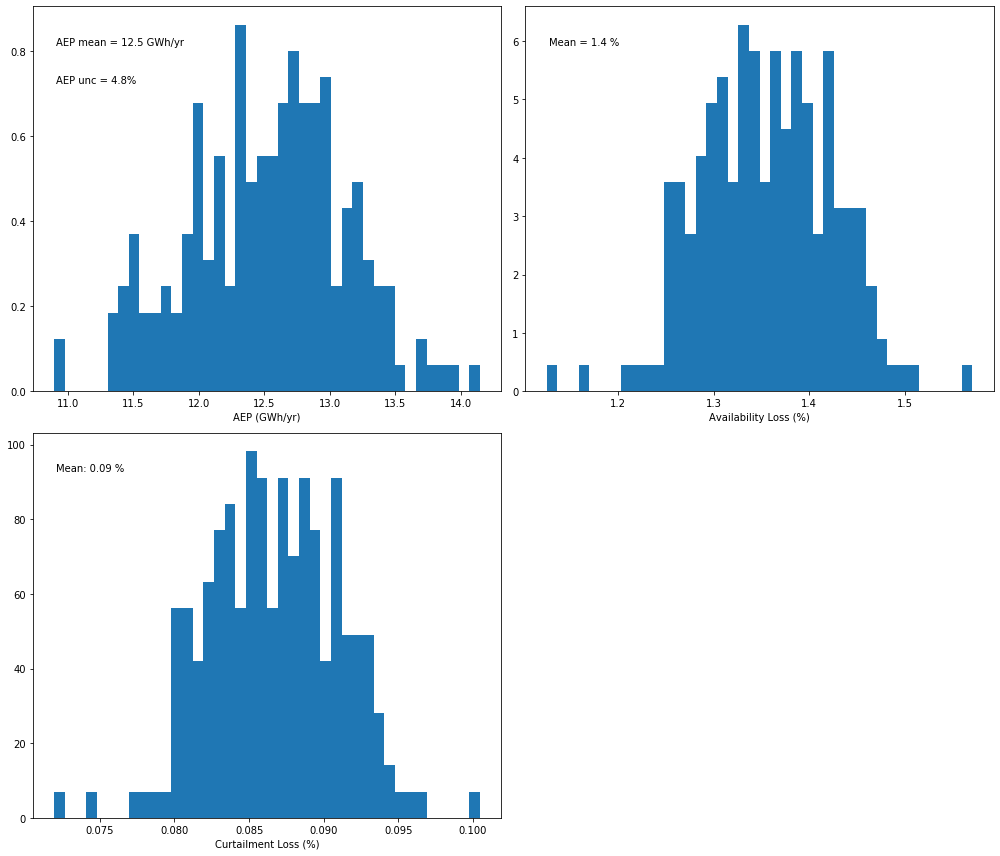

In [19]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gam model
pa_gam.plot_result_aep_distributions().show()

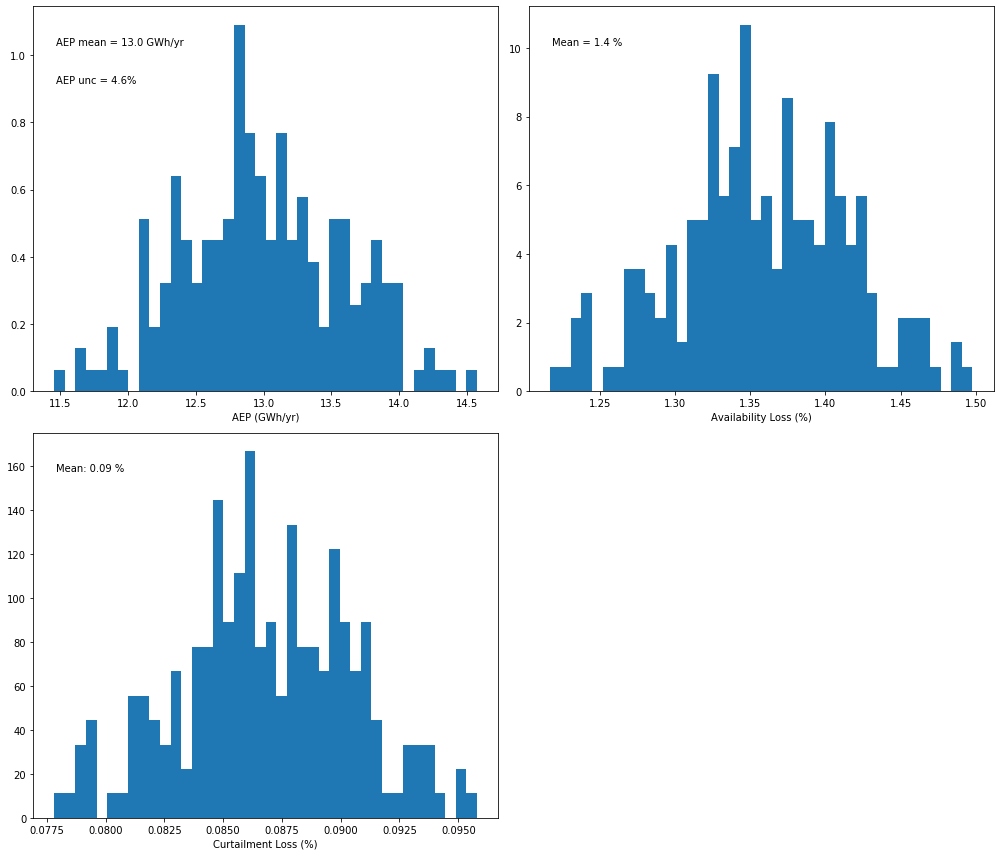

In [20]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gradient boosting model
pa_gbm.plot_result_aep_distributions().show()

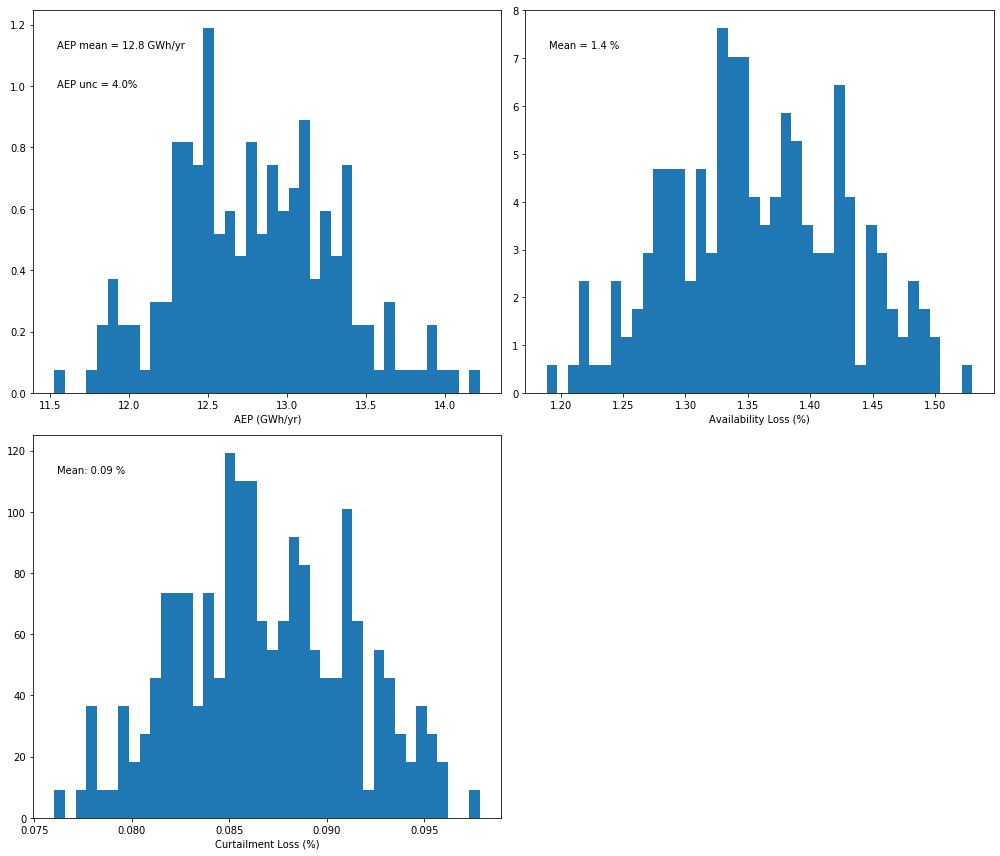

In [21]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - extra randomized tree model
pa_etr.plot_result_aep_distributions().show()

Compared to the daily resolution AEP analysis using the default linear regression method from comparison 1, the machine learning methods tend to estimate slightly higher AEP values with slightly lower uncertainty. 